In [2]:
import pandas as pd
import ast
import re

def parse_tensor_string(tensor_string):
    try:
        return ast.literal_eval(tensor_string.replace("tensor(", "").replace(")", ""))
    except:
        return tensor_string

def process_iqm_data(category):
    # List of files for each category
    files = [
        f'{category}_g1_iqm.csv',
        f'{category}_g2_iqm.csv',
        f'{category}_g3_iqm.csv',
        f'{category}_g4_iqm.csv',
        f'{category}_g5_iqm.csv'
    ]
    
    all_data = []
    for file in files:
        df = pd.read_csv(f'{category}/{file}')
        motion_level = int(re.search(r'g(\d+)', file).group(1))
        df['Motion_Level'] = motion_level
        all_data.append(df)
    
    if not all_data:
        return  # If no data was appended, skip processing
    
    combined_df = pd.concat(all_data, ignore_index=True)
    
    for column in combined_df.columns:
        combined_df[column] = combined_df[column].apply(parse_tensor_string)
    
    combined_df.to_csv(f'{category}/combined_{category}_iqm.csv', index=False)

# Process each category
for category in ['t1', 't2', 't1post', 'flair']:
    process_iqm_data(category)

In [3]:
files = {
    "t1": "t1/combined_t1_iqm.csv",
    "t2": "t2/combined_t2_iqm.csv",
    "t1post": "t1post/combined_t1post_iqm.csv",
    "flair": "flair/combined_flair_iqm.csv"
}

dataframes = []

for sequence_name, file_path in files.items():
    df = pd.read_csv(file_path)
    df["sequence"] = sequence_name
    dataframes.append(df)

combined_df = pd.concat(dataframes, ignore_index=True)
combined_df.to_csv("fr-iqm.csv", index=False)

combined_df

,Subject ID,Slice Index,Haarpsi,VSI,VIF,NQM,Motion_Level,sequence
0,brain_AXT1_201_6002836,0,0.991571,0.9983,0.8545,39.357306,1,t1
1,brain_AXT1_201_6002836,1,0.957855,0.9962,0.7427,32.222995,1,t1
2,brain_AXT1_201_6002836,2,0.957235,0.9956,0.7681,33.599261,1,t1
3,brain_AXT1_201_6002836,3,0.995300,0.9992,0.9139,39.143707,1,t1
4,brain_AXT1_201_6002836,4,0.982608,0.9977,0.8573,37.302301,1,t1
...,...,...,...,...,...,...,...,...
36115,brain_AXFLAIR_200_6002435,11,0.919716,0.9847,0.4179,26.975955,5,flair
36116,brain_AXFLAIR_200_6002435,12,0.900267,0.9816,0.3290,26.763589,5,flair
36117,brain_AXFLAIR_200_6002435,13,0.869715,0.9821,0.2858,16.837184,5,flair
36118,brain_AXFLAIR_200_6002435,14,0.870204,0.9813,0.2365,24.291266,5,flair


In [15]:
import numpy as np

def bin_iqm(df, column_names):
    df_copy = df.copy()
    
    for column_name in column_names:
        data = df_copy[column_name]
        
        counts, bin_edges = np.histogram(data, bins=100, range=(data.min(), data.max()))
        bin_indices = np.digitize(data, bins=bin_edges[:-1], right=False) - 1

        bin_indices = np.clip(bin_indices, 0, 99)

        df_copy[column_name] = bin_indices
    
    return df_copy

In [22]:
columns = ['Haarpsi', 'VSI', 'VIF', 'NQM']
filtered_df = combined_df[(combined_df["Slice Index"] < 10)]
binned_df = bin_iqm(filtered_df, columns)
binned_df

,Subject ID,Slice Index,Haarpsi,VSI,VIF,NQM,Motion_Level,sequence
0,brain_AXT1_201_6002836,0,98,98,85,68,1,t1
1,brain_AXT1_201_6002836,1,94,97,74,57,1,t1
2,brain_AXT1_201_6002836,2,94,97,76,59,1,t1
3,brain_AXT1_201_6002836,3,99,99,91,67,1,t1
4,brain_AXT1_201_6002836,4,97,98,85,65,1,t1
...,...,...,...,...,...,...,...,...
36109,brain_AXFLAIR_200_6002435,5,87,90,51,58,5,flair
36110,brain_AXFLAIR_200_6002435,6,82,85,43,50,5,flair
36111,brain_AXFLAIR_200_6002435,7,90,89,50,59,5,flair
36112,brain_AXFLAIR_200_6002435,8,92,92,52,55,5,flair


In [23]:
t1 = binned_df[binned_df['sequence'] == 't1']
t2 = binned_df[binned_df['sequence'] == 't2']
t1post = binned_df[binned_df['sequence'] == 't1post']
flair = binned_df[binned_df['sequence'] == 'flair']

In [28]:
max_min_values = t1.groupby('Motion_Level')[['Haarpsi', 'VSI', 'VIF', 'NQM']].agg(['min', 'max'])

max_min_values

Haarpsi     VSI     VIF     NQM    
                 min max min max min max min max
Motion_Level                                    
1                 90  99  95  99  65  99  44  99
2                 78  99  84  99  46  93  37  79
3                 74  99  82  99  41  88  35  75
4                 72  99  80  99  38  82  34  71
5                 70  98  79  98  30  74  29  70

/tmp/ipykernel_1593005/1997629621.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Motion_Level', y=column, data=t1, palette='bright')


/tmp/ipykernel_1593005/1997629621.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Motion_Level', y=column, data=t1, palette='bright')
/tmp/ipykernel_1593005/1997629621.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Motion_Level', y=column, data=t1, palette='bright')
/tmp/ipykernel_1593005/1997629621.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Motion_Level', y=column, data=t1, palette='bright')


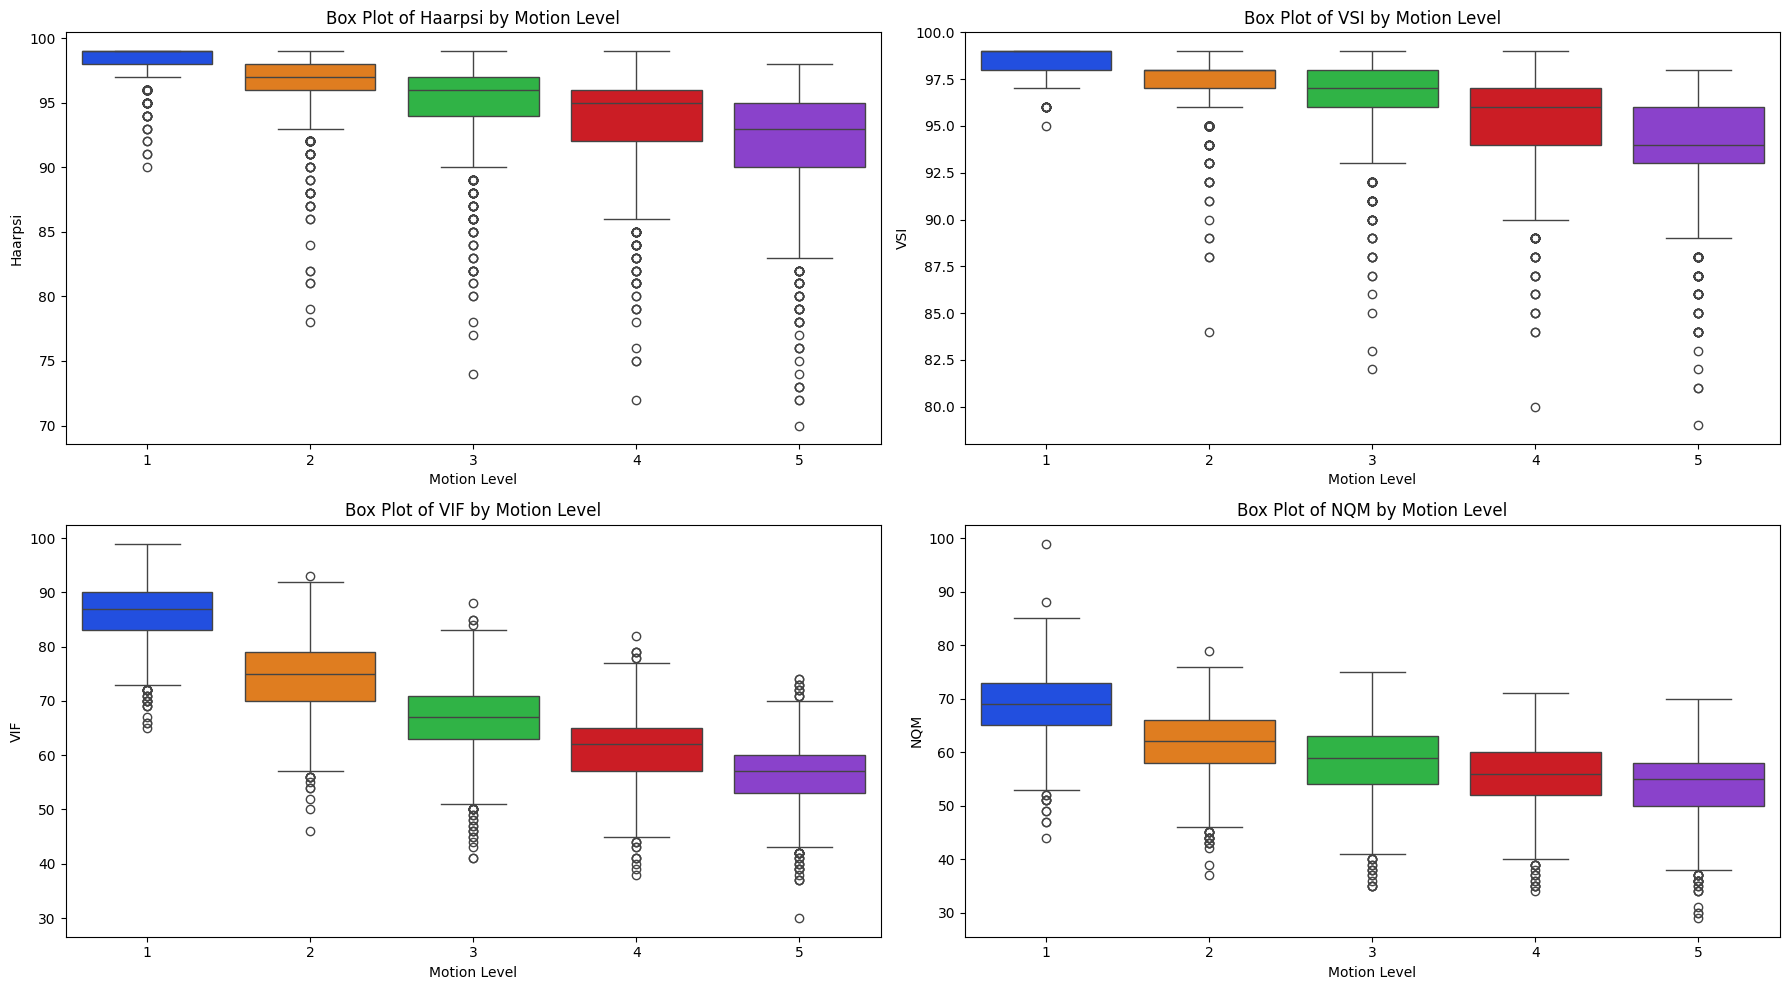

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18, 10))

for i, column in enumerate(['Haarpsi', 'VSI', 'VIF', 'NQM'], 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='Motion_Level', y=column, data=t1, palette='bright')
    plt.title(f'Box Plot of {column} by Motion Level')
    plt.xlabel('Motion Level')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

In [30]:
max_min_values = t1post.groupby('Motion_Level')[['Haarpsi', 'VSI', 'VIF', 'NQM']].agg(['min', 'max'])

max_min_values

Haarpsi     VSI     VIF     NQM    
                 min max min max min max min max
Motion_Level                                    
1                 27  99  73  99  21  98  18  88
2                 21  99  62  99  18  92  13  80
3                 13  99  54  99  12  91  13  75
4                  2  99  22  99   3  83   9  74
5                  1  99   0  98   0  79   5  71

/tmp/ipykernel_1593005/3814550171.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Motion_Level', y=column, data=t1post, palette='bright')


/tmp/ipykernel_1593005/3814550171.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Motion_Level', y=column, data=t1post, palette='bright')
/tmp/ipykernel_1593005/3814550171.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Motion_Level', y=column, data=t1post, palette='bright')
/tmp/ipykernel_1593005/3814550171.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Motion_Level', y=column, data=t1post, palette='bright')


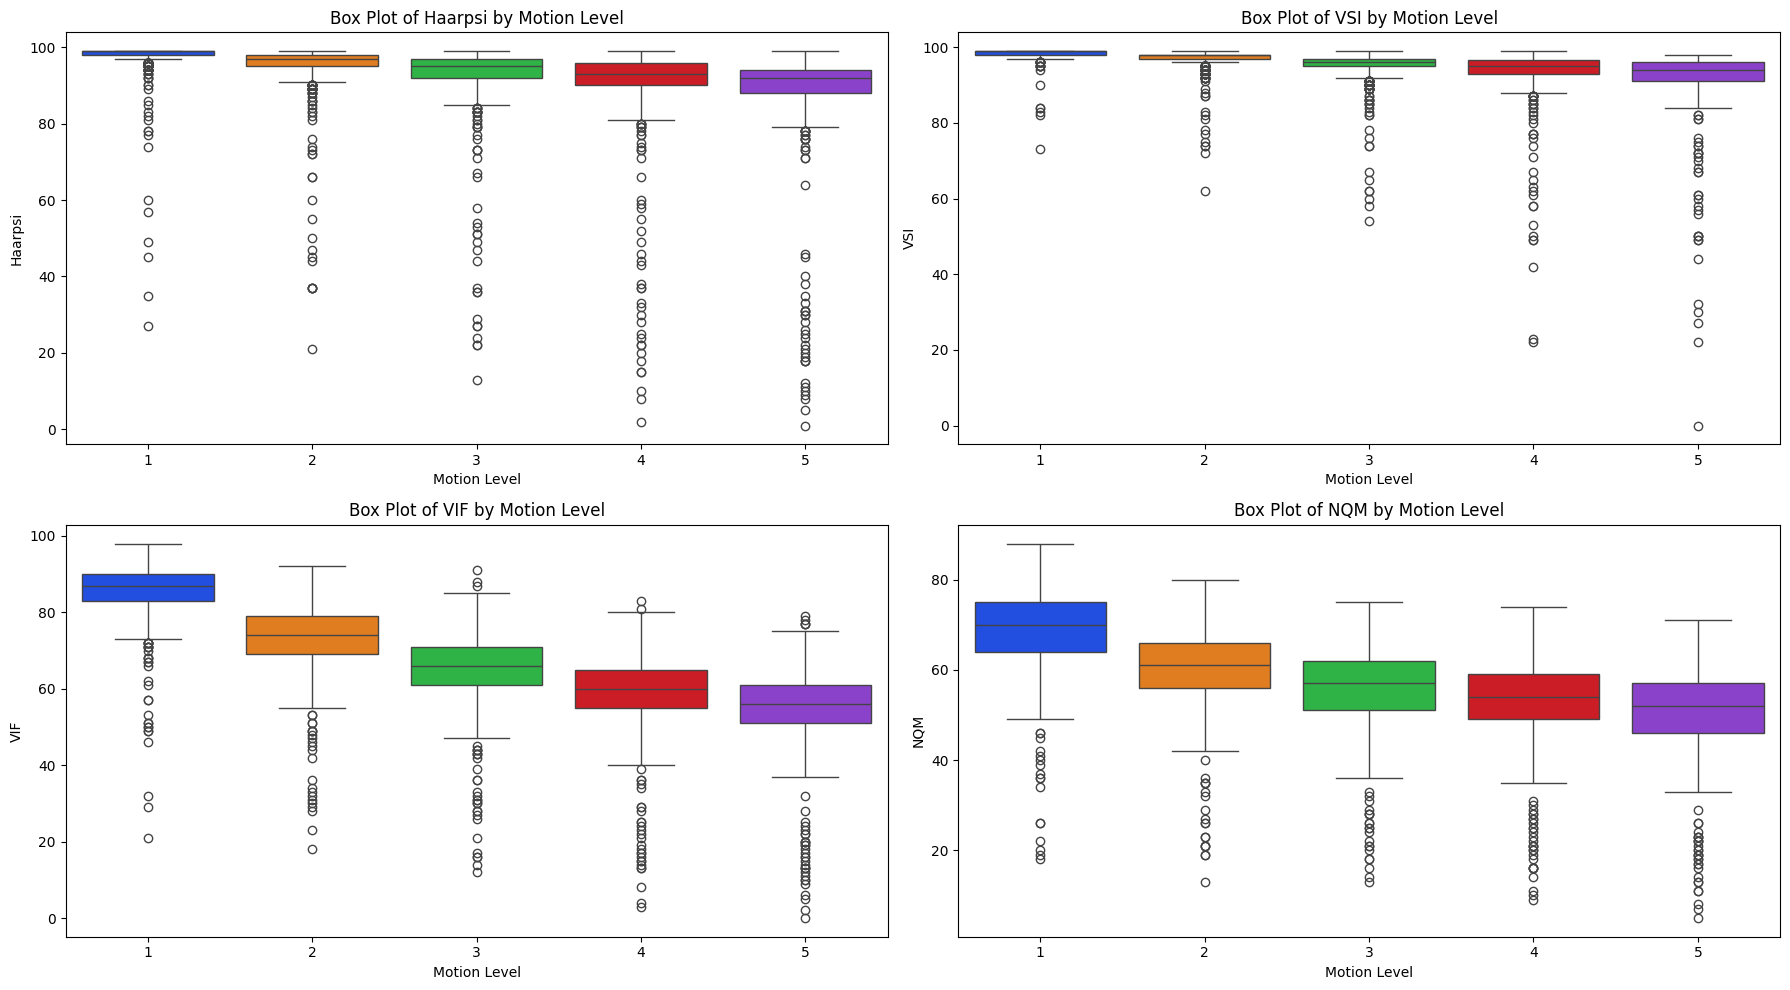

In [31]:
plt.figure(figsize=(18, 10))

for i, column in enumerate(['Haarpsi', 'VSI', 'VIF', 'NQM'], 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='Motion_Level', y=column, data=t1post, palette='bright')
    plt.title(f'Box Plot of {column} by Motion Level')
    plt.xlabel('Motion Level')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

In [34]:
max_min_values = flair.groupby('Motion_Level')[['Haarpsi', 'VSI', 'VIF', 'NQM']].agg(['min', 'max'])

max_min_values

Haarpsi     VSI     VIF     NQM    
                 min max min max min max min max
Motion_Level                                    
1                 23  99  54  99   3  99   5  96
2                 19  99  49  99  10  92  10  75
3                  8  99  36  99   1  91   4  70
4                  7  98  23  99   0  81   1  66
5                  0  99  13  99   0  79   0  63

/tmp/ipykernel_1593005/3343813805.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Motion_Level', y=column, data=flair, palette='bright')
/tmp/ipykernel_1593005/3343813805.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Motion_Level', y=column, data=flair, palette='bright')
/tmp/ipykernel_1593005/3343813805.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Motion_Level', y=column, data=flair, palette='bright')
/tmp/ipykernel_1593005/3343813805.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated an

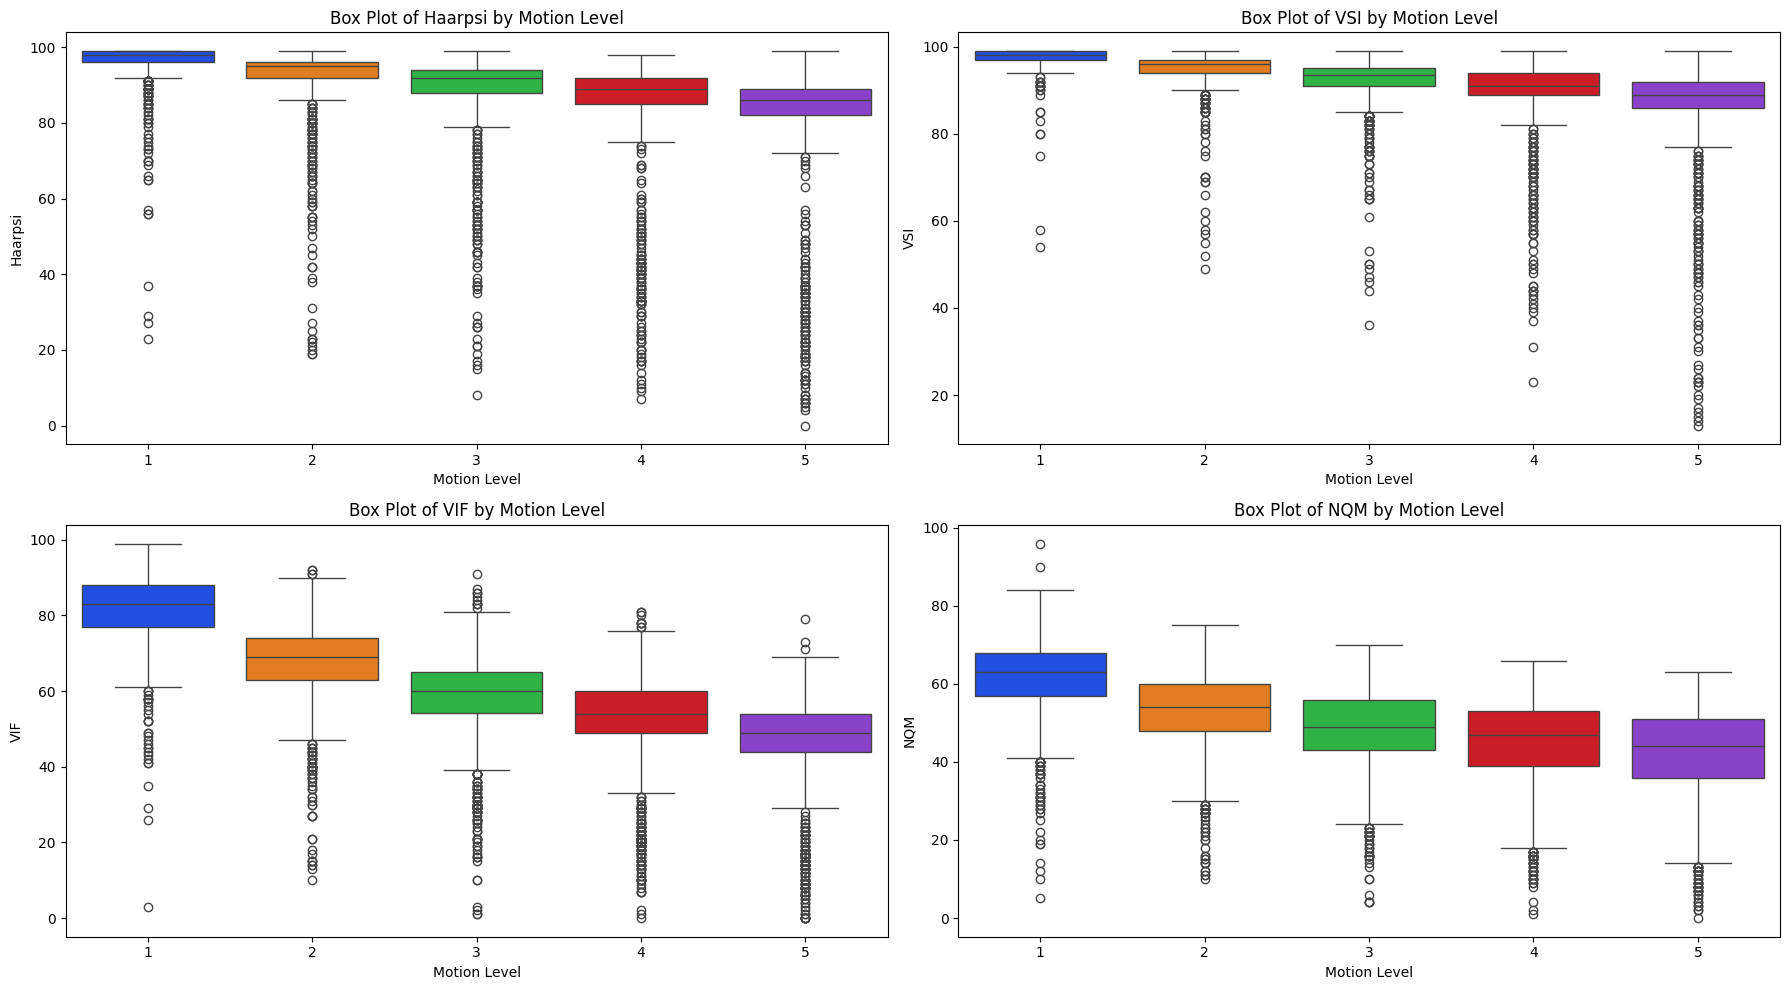

In [35]:
plt.figure(figsize=(18, 10))

for i, column in enumerate(['Haarpsi', 'VSI', 'VIF', 'NQM'], 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='Motion_Level', y=column, data=flair, palette='bright')
    plt.title(f'Box Plot of {column} by Motion Level')
    plt.xlabel('Motion Level')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

In [32]:
max_min_values = t2.groupby('Motion_Level')[['Haarpsi', 'VSI', 'VIF', 'NQM']].agg(['min', 'max'])

max_min_values

Haarpsi     VSI     VIF     NQM    
                 min max min max min max min max
Motion_Level                                    
1                 12  99  40  99   8  98   9  86
2                  9  99  26  99   5  89   6  78
3                  7  98  12  99   2  78   6  71
4                  3  98   4  99   0  76   6  70
5                  5  97   5  99   1  71   4  70

/tmp/ipykernel_1593005/4145790494.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Motion_Level', y=column, data=t2, palette='bright')


/tmp/ipykernel_1593005/4145790494.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Motion_Level', y=column, data=t2, palette='bright')
/tmp/ipykernel_1593005/4145790494.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Motion_Level', y=column, data=t2, palette='bright')
/tmp/ipykernel_1593005/4145790494.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Motion_Level', y=column, data=t2, palette='bright')


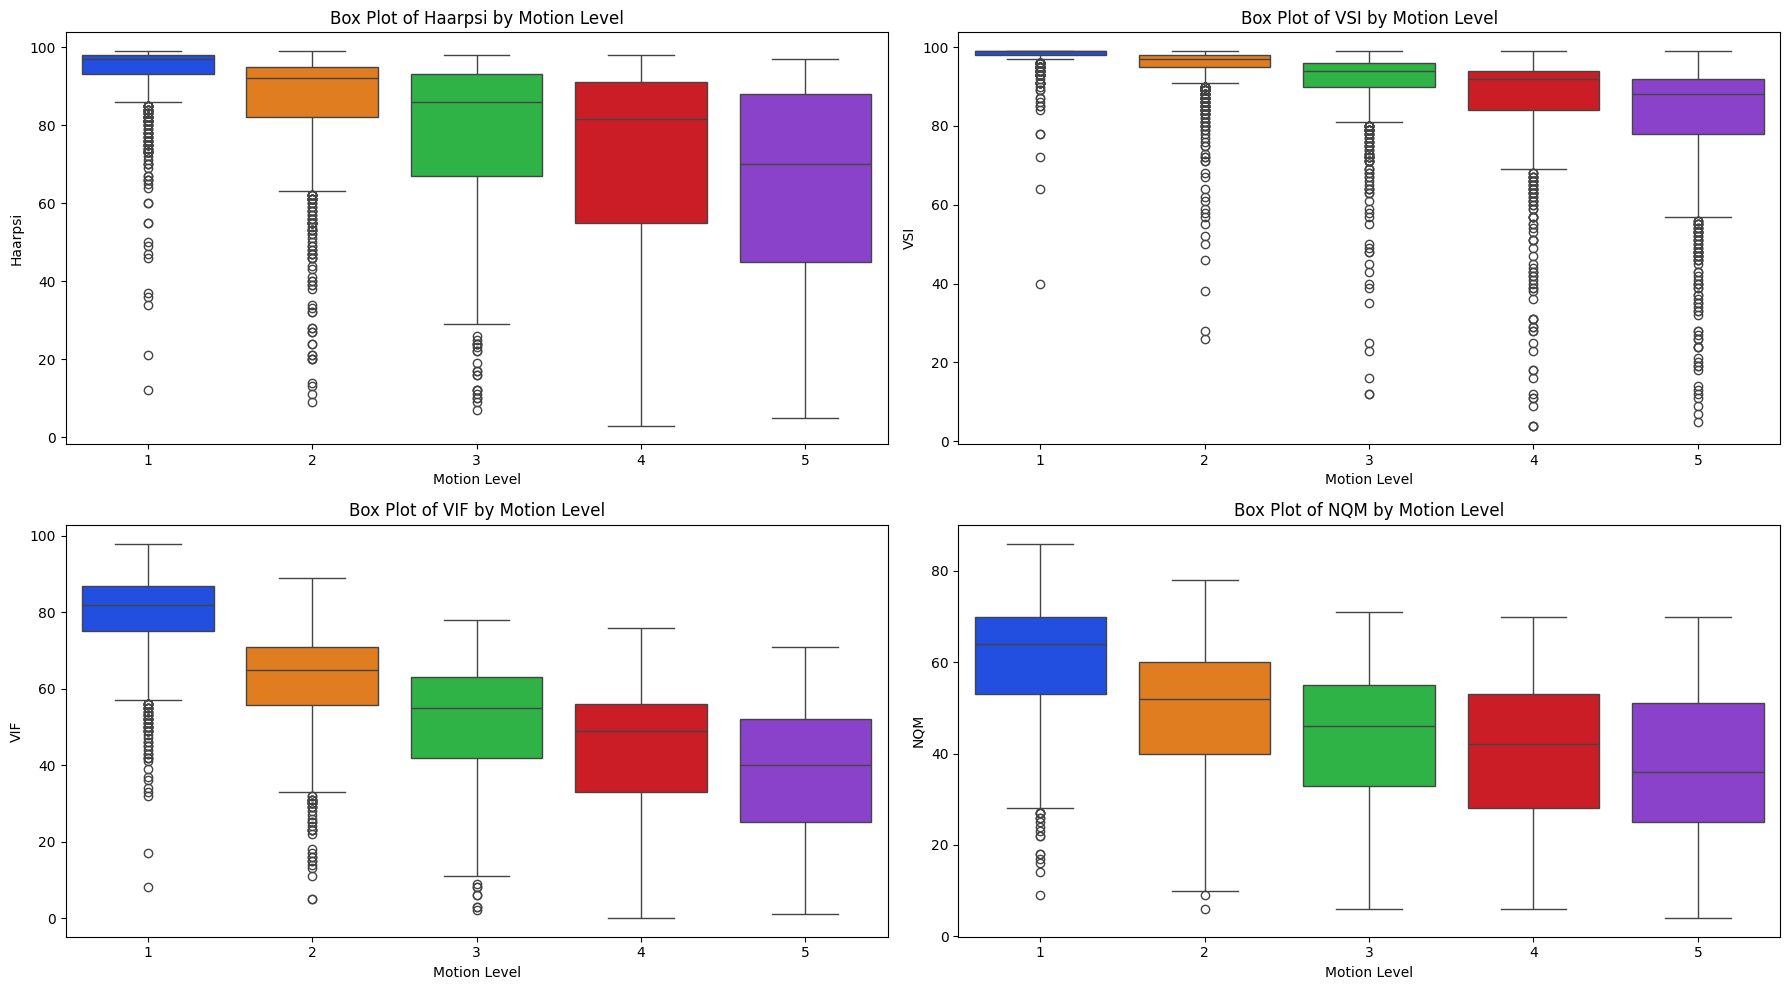

In [33]:
plt.figure(figsize=(18, 10))

for i, column in enumerate(['Haarpsi', 'VSI', 'VIF', 'NQM'], 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='Motion_Level', y=column, data=t2, palette='bright')
    plt.title(f'Box Plot of {column} by Motion Level')
    plt.xlabel('Motion Level')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

In [26]:
t1_df = filtered_df[filtered_df['sequence'] == 't1']
t2_df = filtered_df[filtered_df['sequence'] == 't2']
t1post_df = filtered_df[filtered_df['sequence'] == 't1post']
flair_df = filtered_df[filtered_df['sequence'] == 'flair']

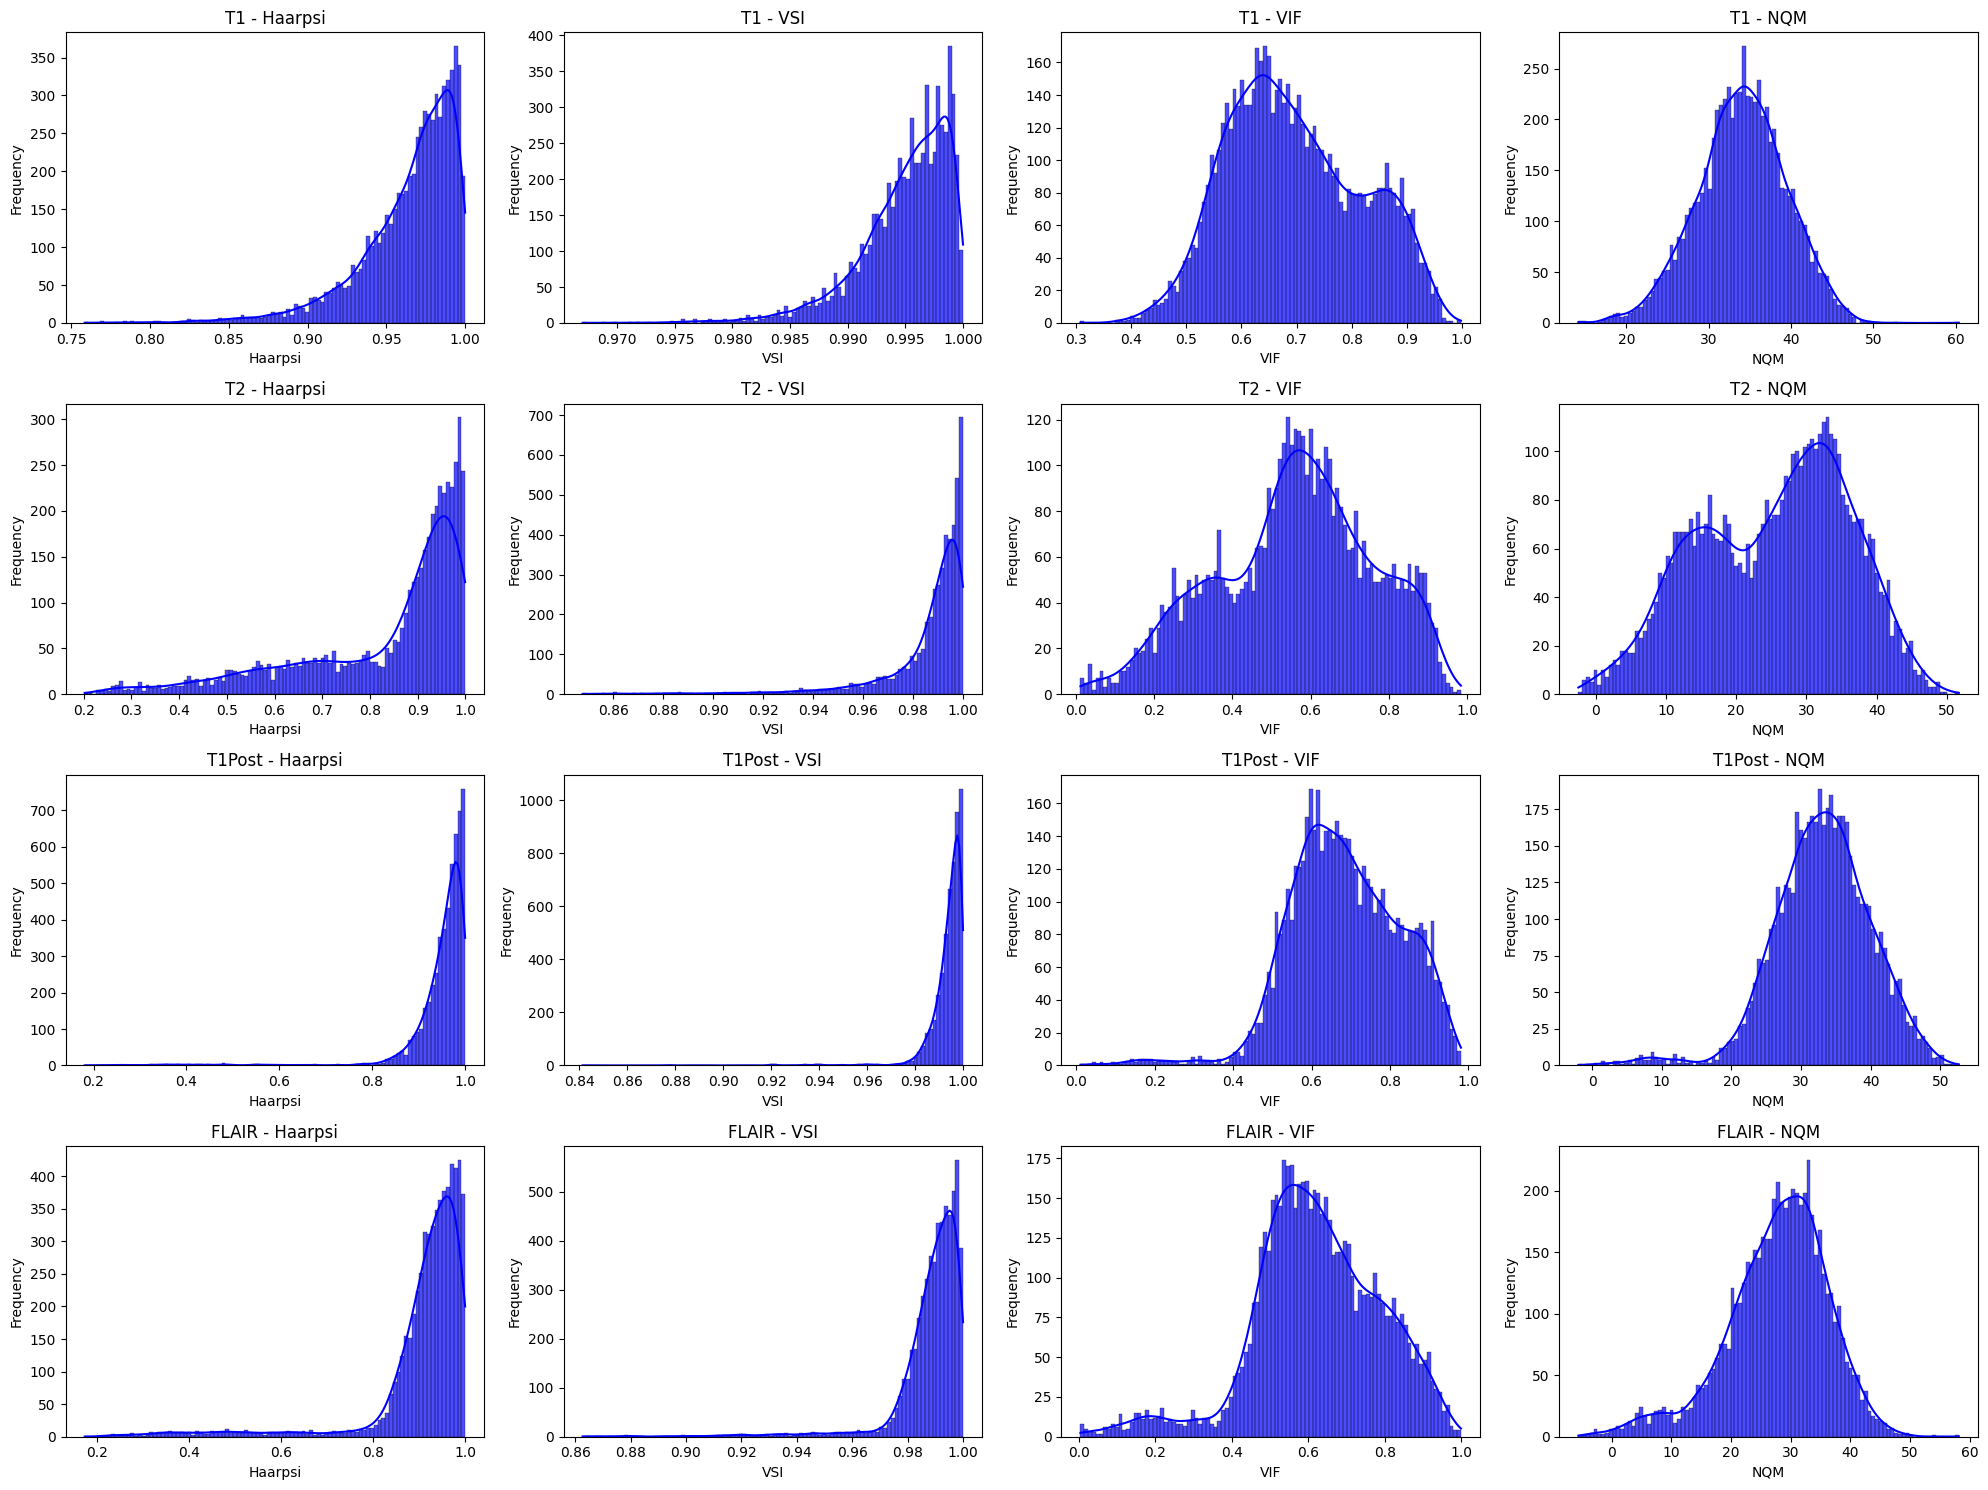

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

dfs = {
    'T1': t1_df,
    'T2': t2_df,
    'T1Post': t1post_df,
    'FLAIR': flair_df
}
columns = ['Haarpsi', 'VSI', 'VIF', 'NQM']

plt.figure(figsize=(20, 15))
plot_index = 1

for df_name, df in dfs.items():
    for column in columns:
        plt.subplot(len(dfs), len(columns), plot_index)
        sns.histplot(df[column], kde=True, bins=100, color='blue', alpha=0.7)
        plt.title(f'{df_name} - {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plot_index += 1

plt.tight_layout()
plt.show()